In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score 


In [2]:
train = pd.read_pickle('data/train_catboost_data_06.pkl')
train.shape

(1429, 85)

In [3]:
train.isnull().sum().sort_values(ascending=False).sum()

0

In [4]:
y = train['SalePrice']

In [5]:
cat_features = train.select_dtypes(include= 'category').columns
num_features = train.select_dtypes(exclude ='category').columns
num_features = num_features.drop('SalePrice')
len(cat_features) , len(num_features)

(67, 17)

In [6]:
train_cat = train[cat_features]
train_num = train[num_features]

In [7]:
train_num.isnull().sum().sum() , train_cat.isnull().sum().sum()

(0, 0)

In [8]:
def get_one_hot_encoded_X(X, dummy_trap=True, delete_original_cat= True):
    cat_cols = X.columns
    
    for col in cat_cols:
        
        temp = pd.get_dummies(X[col], prefix=col, dummy_na=False, drop_first=True)
        X = X.join(temp)

    if delete_original_cat:    
        X = X.drop(cat_cols, axis =1)   
        
    return X  

In [9]:
train_cat = get_one_hot_encoded_X(train_cat, dummy_trap= True, delete_original_cat= True)
train_cat.shape

(1429, 344)

## Modeling

In [10]:
train = pd.concat([train_num, train_cat], axis =1)
train.shape

(1429, 361)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.3, random_state=0 )
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

X_train : (1000, 361)
X_test : (429, 361)
y_train : (1000,)
y_test : (429,)


In [12]:
## Standardized numerical features only 

sc = StandardScaler()

In [13]:

X_train.loc[:, num_features] = sc.fit_transform(X_train.loc[:, num_features])

X_test.loc[:, num_features] = sc.transform(X_test.loc[:, num_features])

/Users/adeela/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/adeela/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [14]:
scorer = make_scorer(mean_squared_error, greater_is_better=False)

In [15]:
def rmse_cv_train(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train, scoring=scorer, cv=10))
    return rmse

In [16]:
def rmse_cv_test(model):
    rmse = np.sqrt(-cross_val_score(model, X_test, y_test, scoring=scorer, cv=10))
    return rmse

## Linear Regression

In [17]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [18]:
print('RMSE on Train: {}'.format(rmse_cv_train(lr).mean()))
print('RMSE on Test: {}'.format(rmse_cv_test(lr).mean()))


RMSE on Train: 2982778655.8396416
RMSE on Test: 82779682141.95432


In [19]:
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

In [20]:
print('R^2: {}'.format(r2_score(y_test, y_pred_test)))

R^2: -1.7373693173074287e+20


### Residuals plot

In [21]:
## PLOT RESIDUALS
#residual = observed - predicted
residual_train = y_pred_train - y_train
residual_test = y_pred_test - y_test 

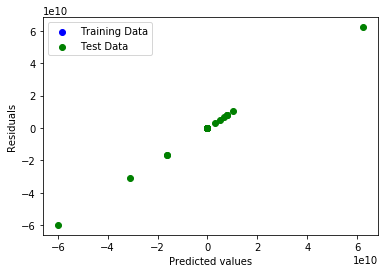

In [22]:
plt.scatter(y_pred_train, residual_train, label ="Training Data", marker='o', color='blue')
plt.scatter(y_pred_test, residual_test, label ="Test Data", marker='o', color='green')
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend()
plt.show()

### Predictions plot

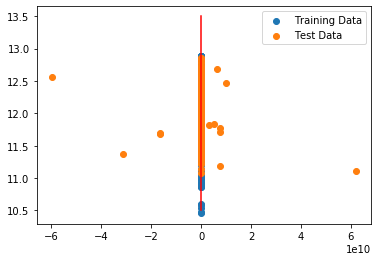

In [23]:
plt.scatter(y_pred_train, y_train, label='Training Data')
plt.scatter(y_pred_test, y_test, label='Test Data')
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.legend()
plt.show()

## Linear Regression with Ridge regularization (L2-penalty)

In [24]:
from sklearn.linear_model import RidgeCV

In [25]:
alphas = np.linspace(0.01, 10, 15)
alphas

array([ 0.01      ,  0.72357143,  1.43714286,  2.15071429,  2.86428571,
        3.57785714,  4.29142857,  5.005     ,  5.71857143,  6.43214286,
        7.14571429,  7.85928571,  8.57285714,  9.28642857, 10.        ])

In [26]:
ridge = RidgeCV(alphas)
ridge.fit(X_train, y_train)

RidgeCV(alphas=array([ 0.01      ,  0.72357143,  1.43714286,  2.15071429,  2.86428571,
        3.57785714,  4.29142857,  5.005     ,  5.71857143,  6.43214286,
        7.14571429,  7.85928571,  8.57285714,  9.28642857, 10.        ]),
        cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
        scoring=None, store_cv_values=False)

In [27]:
print("Best Alpha {}".format(ridge.alpha_))
alphas = np.linspace(0.5,2, 10) *ridge.alpha_ 
alphas

Best Alpha 5.718571428571429


array([ 2.85928571,  3.81238095,  4.76547619,  5.71857143,  6.67166667,
        7.6247619 ,  8.57785714,  9.53095238, 10.48404762, 11.43714286])

In [28]:
ridge = RidgeCV(alphas)
ridge.fit(X_train, y_train)
print("Best Alpha {}".format(ridge.alpha_))

Best Alpha 5.718571428571429


In [29]:
print('RMSE on Train: {}'.format(rmse_cv_train(ridge).mean()))
print('RMSE on Test: {}'.format(rmse_cv_test(ridge).mean()))



RMSE on Train: 0.1217133909469661
RMSE on Test: 0.10786226620292187


In [30]:
y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)
print('R^2: {}'.format(r2_score(y_test, y_pred_test)))

R^2: 0.906239080417491


In [31]:
residual_train = y_pred_train - y_train
residual_test = y_pred_test - y_test 

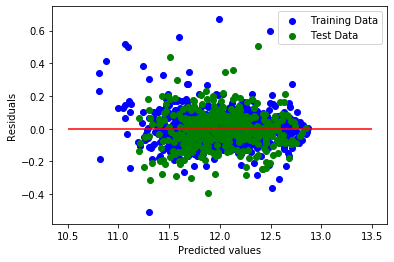

In [32]:
plt.scatter(y_pred_train, residual_train, label ="Training Data", marker='o', color='blue')
plt.scatter(y_pred_test, residual_test, label ="Test Data", marker='o', color='green')
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend()
plt.show()

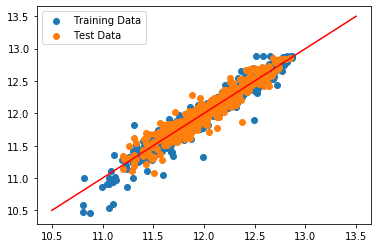

In [33]:
plt.scatter(y_pred_train, y_train, label='Training Data')
plt.scatter(y_pred_test, y_test, label='Test Data')
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.legend()
plt.show()

In [34]:
coef = pd.Series(ridge.coef_ , index= X_train.columns)

In [35]:
len(coef)

361

In [36]:
print("Ridge picked {} columns".format(sum(coef != 0)))
print("Ridge dropped {} columns".format(sum(coef == 0))) 

Ridge picked 327 columns
Ridge dropped 34 columns


In [37]:
coef= coef.sort_values()

In [38]:
coef.head(10)

MSZoning_C (all)        -0.196745
OverallCond_3           -0.138588
OverallQual_3           -0.087991
Functional_Maj2         -0.081849
SaleCondition_Abnorml   -0.079597
Neighborhood_MeadowV    -0.078642
OverallCond_4           -0.070716
Neighborhood_Edwards    -0.062803
TotRmsAbvGrd_11         -0.061059
Heating_Grav            -0.059835
dtype: float64

In [39]:
coef.tail(10)

OverallCond_8           0.067488
Condition1_Norm         0.071624
MSZoning_RH             0.072223
MSZoning_FV             0.073365
Neighborhood_Crawfor    0.083447
OverallCond_9           0.085449
CentralAir_Y            0.088053
Neighborhood_StoneBr    0.090415
OverallQual_9           0.099179
GrLivArea               0.128076
dtype: float64

In [40]:
imp_coef = pd.concat([coef.head(10), 
         coef.tail(10)])

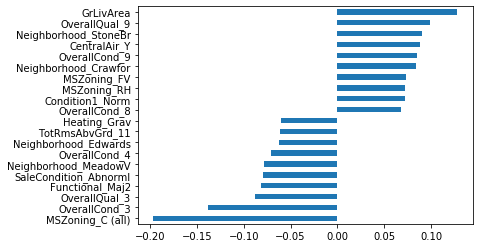

In [41]:
imp_coef.plot(kind='barh')

## Linear Regression with Lasso regularization (L1-penalty)

In [42]:
from sklearn.linear_model import LassoCV

In [43]:
alphas = np.linspace(0.01, 10, 15)

lasso = LassoCV(alphas=alphas, max_iter=50000, cv=10, random_state=True)

lasso.fit(X_train, y_train)

LassoCV(alphas=array([ 0.01      ,  0.72357143,  1.43714286,  2.15071429,  2.86428571,
        3.57785714,  4.29142857,  5.005     ,  5.71857143,  6.43214286,
        7.14571429,  7.85928571,  8.57285714,  9.28642857, 10.        ]),
        copy_X=True, cv=10, eps=0.001, fit_intercept=True, max_iter=50000,
        n_alphas=100, n_jobs=None, normalize=False, positive=False,
        precompute='auto', random_state=True, selection='cyclic', tol=0.0001,
        verbose=False)

In [44]:
print("Best Alpha {}".format(lasso.alpha_))

Best Alpha 0.01


In [45]:
alphas = np.linspace(0.001, 0.2, 15) * lasso.alpha_
alphas

array([1.00000000e-05, 1.52142857e-04, 2.94285714e-04, 4.36428571e-04,
       5.78571429e-04, 7.20714286e-04, 8.62857143e-04, 1.00500000e-03,
       1.14714286e-03, 1.28928571e-03, 1.43142857e-03, 1.57357143e-03,
       1.71571429e-03, 1.85785714e-03, 2.00000000e-03])

In [46]:
lasso = LassoCV(alphas=alphas, max_iter=50000, cv=10, random_state=True)

lasso.fit(X_train, y_train)

LassoCV(alphas=array([1.00000000e-05, 1.52142857e-04, 2.94285714e-04, 4.36428571e-04,
       5.78571429e-04, 7.20714286e-04, 8.62857143e-04, 1.00500000e-03,
       1.14714286e-03, 1.28928571e-03, 1.43142857e-03, 1.57357143e-03,
       1.71571429e-03, 1.85785714e-03, 2.00000000e-03]),
        copy_X=True, cv=10, eps=0.001, fit_intercept=True, max_iter=50000,
        n_alphas=100, n_jobs=None, normalize=False, positive=False,
        precompute='auto', random_state=True, selection='cyclic', tol=0.0001,
        verbose=False)

In [47]:
print("Best Alpha {}".format(lasso.alpha_))

Best Alpha 0.0004364285714285715


In [48]:
print('RMSE on Train: {}'.format(rmse_cv_train(lasso).mean()))
print('RMSE on Test: {}'.format(rmse_cv_test(lasso).mean()))


RMSE on Train: 0.12108834686319365
RMSE on Test: 0.1065081489849012


In [49]:
y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)
print('R^2: {}'.format(r2_score(y_test, y_pred_test)))

R^2: 0.9059914386237113


In [50]:
residual_train = y_pred_train - y_train
residual_test = y_pred_test - y_test 

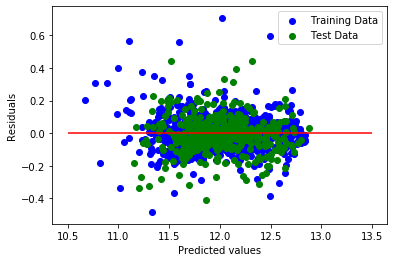

In [51]:
plt.scatter(y_pred_train, residual_train, label ="Training Data", marker='o', color='blue')
plt.scatter(y_pred_test, residual_test, label ="Test Data", marker='o', color='green')
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend()
plt.show()

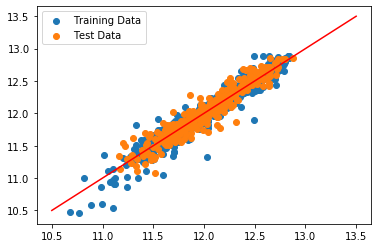

In [52]:
plt.scatter(y_pred_train, y_train, label='Training Data')
plt.scatter(y_pred_test, y_test, label='Test Data')
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.legend()
plt.show()

In [53]:
coef = pd.Series(lasso.coef_ , index= X_train.columns)

In [54]:
print("Lasso picked {} columns".format(sum(coef != 0)))
print("Lasso dropped {} columns".format(sum(coef == 0))) 

Lasso picked 144 columns
Lasso dropped 217 columns


In [55]:
coef= coef.sort_values()

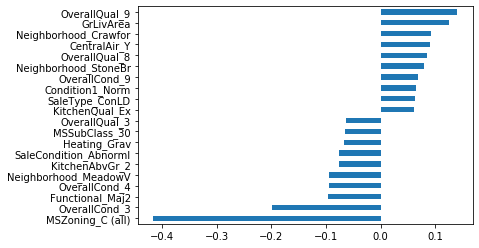

In [56]:
imp_coef = pd.concat([coef.head(10), 
         coef.tail(10)])
imp_coef.plot(kind='barh')

In [57]:
picked_coef_lasso = pd.DataFrame(coef[coef !=0])
picked_coef_lasso

,0
MSZoning_C (all),-0.416235
OverallCond_3,-0.199430
Functional_Maj2,-0.095893
OverallCond_4,-0.094819
Neighborhood_MeadowV,-0.094251
...,...
OverallQual_8,0.084029
CentralAir_Y,0.090475
Neighborhood_Crawfor,0.091745
GrLivArea,0.124277


In [58]:
lasso_cols = picked_coef_lasso.index.tolist()
pd.to_pickle(lasso_cols, 'data/lasso_cols_06.pkl')

## Validate on Test data

In [59]:
test_data = pd.read_pickle('data/test_catboost_data_06.pkl')
test_data.shape

(1459, 85)

In [60]:
Id = test_data['Id']

In [61]:
X = test_data.iloc[:, :-1]
X.shape

(1459, 84)

In [62]:
test_num = X.loc[:, num_features]
test_num.shape

(1459, 17)

In [63]:
test_cat = get_one_hot_encoded_X(X.loc[:, cat_features], dummy_trap= True, delete_original_cat= True)
test_cat.shape

(1459, 344)

In [64]:
test = pd.concat([test_num, test_cat], axis=1)
test.shape

(1459, 361)

In [65]:
test.loc[:, num_features] = sc.transform(test.loc[:, num_features])

In [66]:
test.shape

(1459, 361)

In [67]:
y_hat_test = lasso.predict(test)

In [68]:
submission = pd.DataFrame({'Id': Id, 
             'SalePrice': y_hat_test})
submission.head()

,Id,SalePrice
0,1461,11.697568
1,1462,11.983157
2,1463,12.133197
3,1464,12.206538
4,1465,12.135464


In [69]:
submission.to_csv('data/ah_submission_5.csv', index=False)